## SK_2_141 Data Analysis
#### Experiment: Rate of reaction from UV-Vis spectra
0. Imports

In [2]:
from kinetics.FSQ import compFTOfSpectrum, compSortedEigenSet, compNumEigenVectors, compSEE
from kinetics.initial_rates import compInitialRate, compLeastSquaresRateLaw
from kinetics.json_definitions import readCalibrationData, readKineticData

import os
import numpy
from collections import defaultdict
from matplotlib import pyplot as plt

1. Load the calibration data.

In [3]:
path_to_calibration_data = "SK_2_141/calibration_json"
calibration_data = readCalibrationData(path_to_calibration_data)

2. Create a $w$ by $m$ matrix $M$ holding the absorbance measurements at each wavelength $w$ for each standard mixture $m$, and a corresponding $n$ by $m$ matrix $C$ with the concentrations of each one of the $n$ components in each of the $m$ standard mixtures.

In [4]:
M = numpy.array(calibration_data["absorbances"])
C = numpy.array(calibration_data["concentrations"])
wavelengths = calibration_data["wavelengths"]
component_ids = calibration_data["component_ids"]

3. Compute matrix $F$ by taking the Fourier transform of each of the columns of the absorbance matrix $M$. Select only a consecutive subset of the terms in the Fourier transform by specifying the index of the term at the beginning and the number of terms to include.

In [5]:
path_length = 1.0 #cm
starting_at_term = 2
number_of_terms = 29

F = [
    compFTOfSpectrum(
        #Fourier terms obtained from real, symmetric spectra
        numpy.hstack((numpy.flip(spectrum), spectrum))[:-1],
    ) 
    for spectrum in M.T
]

F = (numpy.array(F).T)[starting_at_term:(starting_at_term + number_of_terms), :]

4. Compute the set of eigenvalues and eigenvectors of the variance-covariance matrix.

In [6]:
eigenvalues, eigenvectors = compSortedEigenSet(F)

5. Compute the number of eigenvectors to use and arrange them in a matrix $V$.

In [7]:
k = compNumEigenVectors(eigenvalues)
V = eigenvectors[:,:k]

6. Compute $Z = V^TF$, $P = CZ^T(ZZ^T)^{-1}$ and $M = PV^{T}$.

In [8]:
Z = numpy.matmul(V.T,F)
P = numpy.matmul(C, numpy.matmul(Z.T,numpy.linalg.inv(numpy.matmul(Z,Z.T))))
M = numpy.matmul(P, V.T)

7. Compute the standard error of estimation, $SEE$.

In [9]:
SEE = compSEE(C,M,F,k)
print(SEE)

0.0014877089004241202


8. Compute the concentration of each component in the mixture at all time points by reading the data from each kinetic experiment file.

In [10]:
path_to_kinetic_data = 'SK_2_141/kinetic_json'
experiments = {}

# Iterate over the kinetic experiment directories.
for directory_name in [directory for directory in os.listdir(path_to_kinetic_data) if not directory.startswith('.')]:
    path_to_directory = os.path.join(path_to_kinetic_data, directory_name)
    
    # Read kinetic experiment data.
    kinetic_experiment = readKineticData(path_to_directory)
    
    # Read time points as relative to the initial time point.
    time_points = kinetic_experiment["time_points"]
    t0 = min(time_points)
    if t0 > 0:
        time_points = list(numpy.array(time_points)-t0)
    
    # Create a matrix holding the absorbance measurements of the mixture.
    mixture_absorbances = numpy.array(kinetic_experiment["absorbances"])
    
    # Compute the Fourier transform of the mixture absorbance matrix.
    mixture_absorbances_FT = [
        compFTOfSpectrum(
            numpy.hstack((numpy.flip(spectrum), spectrum))[:-1], 
            path_length
        ) for spectrum in mixture_absorbances.T
    ]
    
    # Select the same subset of Fourier terms as the calibration absorbance matrix.
    mixture_absorbances_FT = (numpy.array(mixture_absorbances_FT).T)[
        starting_at_term:(starting_at_term + number_of_terms), :]
    
    # Compute concentrations of each component in the mixture.
    concentrations = numpy.matmul(M, mixture_absorbances_FT).real
    
    # Scale concentrations by the dilution factor.
    dilution_factors = numpy.array(kinetic_experiment["dilution_factors"])
    concentrations = concentrations * numpy.reciprocal(dilution_factors)
    
    # Replace negative concentration values with 0.
    concentrations[concentrations < 0] = 0
    
    # Record time points and computed component concentrations in the experiments dictionary
    experiment_id = kinetic_experiment["experiment_id"]
    experiments[experiment_id] = {
        "time_points": time_points,
        "concentrations": [list(c) for c in concentrations],
    }

9. Compute the initial rates by estimating the initial rate of change in concentration of each monitored component.

The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]
 [  1. 300.]
 [  1. 360.]
 [  1. 420.]
 [  1. 480.]]


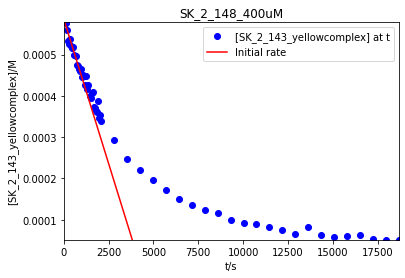

initial_rate =  1.399778861154545e-07 M/s
The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]
 [  1. 300.]
 [  1. 360.]
 [  1. 420.]
 [  1. 480.]
 [  1. 540.]
 [  1. 600.]
 [  1. 660.]]


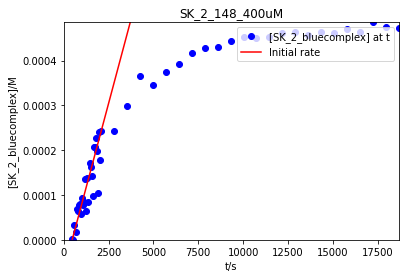

initial_rate =  1.4997634593286385e-07 M/s
[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]
 [  1. 300.]]


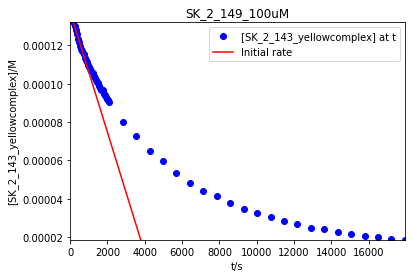

initial_rate =  3.148041090973053e-08 M/s
[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]]


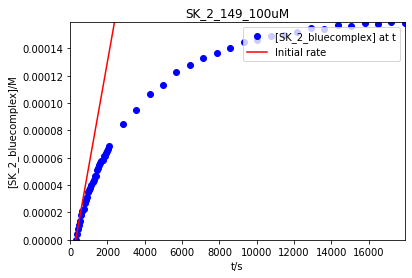

initial_rate =  7.659493813983094e-08 M/s
[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]
 [  1. 300.]
 [  1. 360.]
 [  1. 420.]
 [  1. 480.]
 [  1. 540.]
 [  1. 600.]
 [  1. 660.]
 [  1. 720.]
 [  1. 780.]]


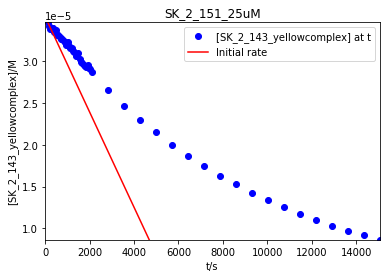

initial_rate =  5.709948901460723e-09 M/s
[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]]


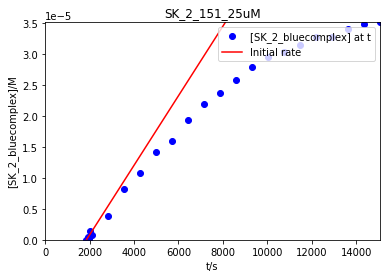

initial_rate =  5.624017038409843e-09 M/s
[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]
 [  1. 300.]]


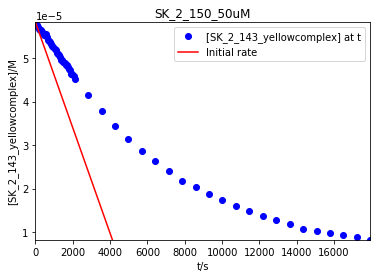

initial_rate =  1.2132805618345474e-08 M/s
[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]
 [  1. 300.]
 [  1. 360.]
 [  1. 420.]
 [  1. 480.]
 [  1. 540.]
 [  1. 600.]
 [  1. 660.]
 [  1. 720.]]


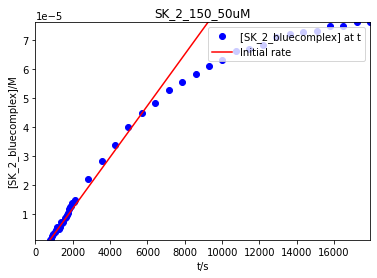

initial_rate =  8.899709419726504e-09 M/s
The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


[[  1.  60.]
 [  1. 120.]
 [  1. 180.]
 [  1. 240.]]


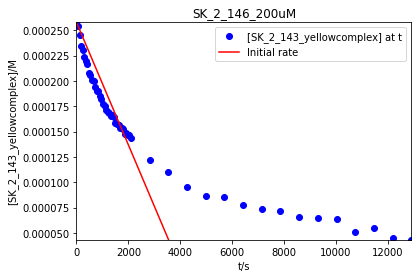

initial_rate =  6.050048235790716e-08 M/s
The reaction percentage specified will probably lead to significant errors in the approximation of the initial rate. Please keep the value of reaction percentage below or at 10%


[[  1.  60.]
 [  1. 120.]
 [  1. 180.]]


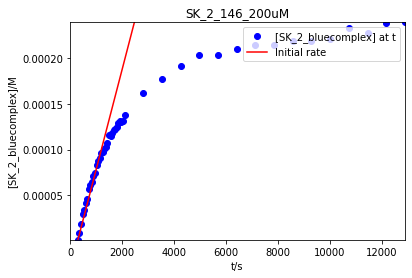

initial_rate =  1.092753770019715e-07 M/s


In [11]:
# Add reaction information associated to each component ordered according to its position in the component id list.
component_is_reactant = [True, False]
stoichiometric_coefficients = [1.0, 1.0]

# Set parameters used to compute the initial rate of change in concentration of each component in each experiment.
experiments['SK_2_146_200uM']['initial_rate_parameters'] = {
    'SK_2_143_yellowcomplex': {
        'time_range': slice(0,len(experiments['SK_2_146_200uM']['time_points'])),
        'reaction_percentage': 15
    },
    'SK_2_bluecomplex': {
        'time_range': slice(5,len(experiments['SK_2_146_200uM']['time_points'])),
        'reaction_percentage': 12
    }
}

experiments['SK_2_148_400uM']['initial_rate_parameters'] = {
    'SK_2_143_yellowcomplex': {
        'time_range': slice(1,len(experiments['SK_2_148_400uM']['time_points'])),
        'reaction_percentage': 12
    },
    'SK_2_bluecomplex': {
        'time_range': slice(8,len(experiments['SK_2_148_400uM']['time_points'])),
        'reaction_percentage': 20
    }
}

experiments['SK_2_149_100uM']['initial_rate_parameters'] = {
    'SK_2_143_yellowcomplex': {
        'time_range': slice(3,len(experiments['SK_2_149_100uM']['time_points'])),
        'reaction_percentage': 10
    },
    'SK_2_bluecomplex': {
        'time_range': slice(5,len(experiments['SK_2_149_100uM']['time_points'])),
        'reaction_percentage': 10
    }
}

experiments['SK_2_150_50uM']['initial_rate_parameters'] = {
    'SK_2_143_yellowcomplex': {
        'time_range': slice(0,len(experiments['SK_2_150_50uM']['time_points'])),
        'reaction_percentage': 4
    },
    'SK_2_bluecomplex': {
        'time_range': slice(13,len(experiments['SK_2_150_50uM']['time_points'])),
        'reaction_percentage': 10
    }
}

experiments['SK_2_151_25uM']['initial_rate_parameters'] = {
    'SK_2_143_yellowcomplex': {
        'time_range': slice(2,len(experiments['SK_2_151_25uM']['time_points'])),
        'reaction_percentage': 10
    },
    'SK_2_bluecomplex': {
        'time_range': slice(31,len(experiments['SK_2_151_25uM']['time_points'])),
        'reaction_percentage': 10
    }
}

experiment_ids = list(experiments.keys())
for experiment_id in experiment_ids:
    initial_rates = []
    for component_index, component_id in enumerate(component_ids):
        experiment = experiments[experiment_id]
        time_range = experiment['initial_rate_parameters'][component_id]['time_range']
        reaction_percentage = experiment['initial_rate_parameters'][component_id]['reaction_percentage']
        time_points_subset = experiment['time_points'][time_range]
        concentrations_subset = experiment['concentrations'][component_index][time_range]
        stoichiometric_coefficient = stoichiometric_coefficients[component_index]
        t = time_points_subset[:]
        time_points_subset = list(numpy.array(time_points_subset)-time_points_subset[0])

        initial_rate = compInitialRate(stoichiometric_coefficient, time_points_subset, concentrations_subset, reaction_percentage)
        initial_rates.append(initial_rate)
        
        # Generate initial rate curve.
        is_reactant = component_is_reactant[component_index]
        initial_rate_curve = concentrations_subset[0]  + numpy.multiply(
            (-1 if is_reactant else 1) * stoichiometric_coefficient * initial_rate,
            time_points_subset)

        # Plot kinetic data and the initial rate curve.
        plt.title(f"{experiment_id}") 
        plt.xlabel("t/s") 
        plt.ylabel(f"[{component_id}]/M") 
        plt.plot(t, concentrations_subset, "-bo", linestyle='none', label = f"[{component_id}] at t")
        plt.plot(t, initial_rate_curve,  "-r", label = "Initial rate")
        plt.legend(loc = "upper right")
        plt.ylim(min(concentrations_subset), max(concentrations_subset))
        plt.xlim(0, t[-1])
        plt.show()
        print("initial_rate = ", initial_rate, "M/s")
    experiments[experiment_id]['initial_rates'] = initial_rates

10. Compute the rate constant and order of SK_2_143_yellowcomplex using linear regression.

SK_2_143 order: 1.1549188005997053
rate constant: 0.0011829479249363356


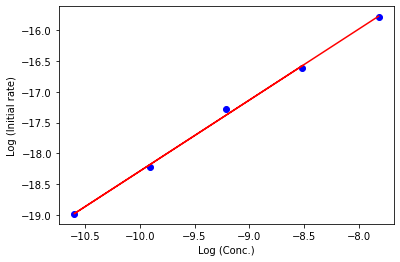

In [12]:
experiments['SK_2_146_200uM']['initial_concentrations'] = [200, 0]
experiments['SK_2_148_400uM']['initial_concentrations'] = [400, 0]
experiments['SK_2_149_100uM']['initial_concentrations'] = [100, 0]
experiments['SK_2_150_50uM']['initial_concentrations'] = [50, 0]
experiments['SK_2_151_25uM']['initial_concentrations'] = [25, 0]

initial_rates = [
    experiments[experiment_id]['initial_rates'][0]
    for experiment_id in experiment_ids
]
initial_concentrations = [
    [numpy.divide(experiments[experiment_id]['initial_concentrations'][0], 1e6)]
    for experiment_id in experiment_ids
]

[rate_constant, m_SK_2_143] = compLeastSquaresRateLaw(initial_concentrations, initial_rates)
fit = [
    numpy.log(rate_constant) + numpy.log(c[0])*m_SK_2_143
    for c in initial_concentrations
]

print(f"SK_2_143 order: {m_SK_2_143}")
print(f"rate constant: {rate_constant}")
plt.xlabel("Log (Conc.)") 
plt.ylabel("Log (Initial rate)") 
plt.plot(numpy.log(initial_concentrations), numpy.log(initial_rates), "-bo", linestyle='none')
plt.plot(numpy.log(initial_concentrations), fit, "-r")
plt.show()

In [13]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = "arial"
rcParams.update({'font.size': 22})
rcParams['legend.loc'] = 'upper left'
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = numpy.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')


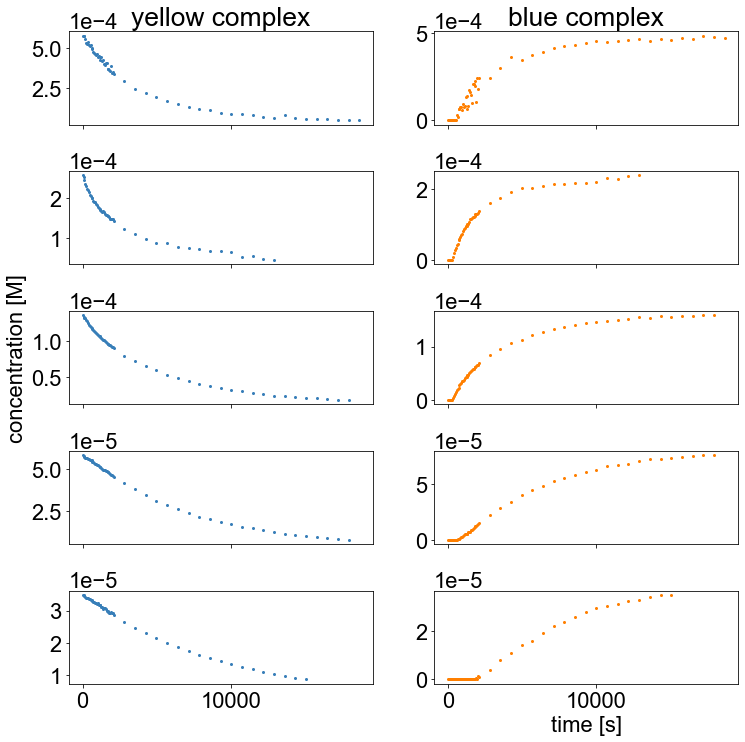

In [14]:
fig = plt.figure(figsize = (12,12))
gs = fig.add_gridspec(5,2, hspace=0.5, wspace = 0.2)
axs = gs.subplots(sharex=True, sharey=False)

axs[0,0].plot(experiments['SK_2_148_400uM']['time_points'], experiments['SK_2_148_400uM']['concentrations'][0], marker = 'o', linestyle = 'none', markersize = 2, color = '#377eb8')
axs[0,0].set_title('yellow complex')
axs[1,0].plot(experiments['SK_2_146_200uM']['time_points'], experiments['SK_2_146_200uM']['concentrations'][0], marker = 'o', linestyle = 'none', markersize = 2, color = '#377eb8')
axs[2,0].plot(experiments['SK_2_149_100uM']['time_points'], experiments['SK_2_149_100uM']['concentrations'][0], marker = 'o', linestyle = 'none', markersize = 2, color = '#377eb8')
axs[3,0].plot(experiments['SK_2_150_50uM']['time_points'], experiments['SK_2_150_50uM']['concentrations'][0], marker = 'o', linestyle = 'none', markersize = 2, color = '#377eb8')
axs[4,0].plot(experiments['SK_2_151_25uM']['time_points'], experiments['SK_2_151_25uM']['concentrations'][0], marker = 'o', linestyle = 'none', markersize = 2, color = '#377eb8')
axs[0,1].plot(experiments['SK_2_148_400uM']['time_points'], experiments['SK_2_148_400uM']['concentrations'][1], marker = 'o', linestyle = 'none', markersize = 2, color = '#ff7f00')
axs[0,1].set_title('blue complex')
axs[1,1].plot(experiments['SK_2_146_200uM']['time_points'], experiments['SK_2_146_200uM']['concentrations'][1], marker = 'o', linestyle = 'none', markersize = 2, color = '#ff7f00')
axs[2,1].plot(experiments['SK_2_149_100uM']['time_points'], experiments['SK_2_149_100uM']['concentrations'][1], marker = 'o', linestyle = 'none', markersize = 2, color = '#ff7f00')
axs[3,1].plot(experiments['SK_2_150_50uM']['time_points'], experiments['SK_2_150_50uM']['concentrations'][1], marker = 'o', linestyle = 'none', markersize = 2, color = '#ff7f00')
axs[4,1].plot(experiments['SK_2_151_25uM']['time_points'], experiments['SK_2_151_25uM']['concentrations'][1], marker = 'o', linestyle = 'none', markersize = 2, color = '#ff7f00')
axs[4,1].set_xlabel('time [s]')
axs[2,0].set_ylabel('concentration [M]')
for i in [0,1,]:
    for j in [0,1,2,3,4]:
        axs[j,i].ticklabel_format(style = 'scientific', scilimits = [-4,6])
        
plt.savefig('/Users/zarko/Documents/zarkolab/projects/nickel_spiroindane/yellow_blue_conversion_1.svg')

In [15]:
experiment_ids

['SK_2_148_400uM',
 'SK_2_149_100uM',
 'SK_2_151_25uM',
 'SK_2_150_50uM',
 'SK_2_146_200uM']

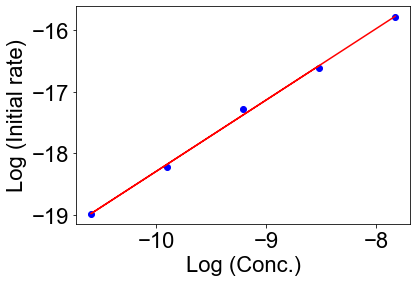

In [16]:
plt.xlabel("Log (Conc.)") 
plt.ylabel("Log (Initial rate)") 
plt.plot(numpy.log(initial_concentrations), numpy.log(initial_rates), "-bo", linestyle='none')
plt.plot(numpy.log(initial_concentrations), fit, "-r")
plt.show()

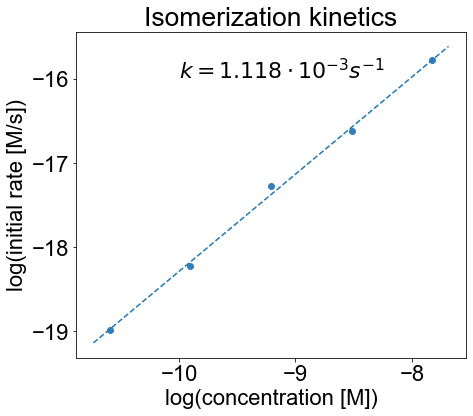

In [17]:
fig = plt.figure(figsize=(7, 6))
plt.plot(numpy.log(initial_concentrations), numpy.log(initial_rates), "-bo", linestyle='none', color = '#377eb8')
plt.xlabel("log(concentration [M])") 
plt.ylabel("log(initial rate [M/s])") 
plt.title('Isomerization kinetics')
#plt.text(0.0042, 2,r'$E_a$ = 11.09 kcal/mol')
abline(m_SK_2_143,numpy.log(rate_constant))
plt.ticklabel_format(style = 'scientific', scilimits = [-4,6])
plt.text(-10, -16,r'$k = 1.118 \cdot 10^{-3} s^{-1}$')
plt.savefig('/Users/zarko/Documents/zarkolab/projects/nickel_spiroindane/isomerization_kinetics.svg')

In [18]:
experiments[experiment_id]['initial_concentrations'][0]

200

In [20]:
component_ids

['SK_2_143_yellowcomplex', 'SK_2_bluecomplex']

In [22]:
experiment['initial_rate_parameters']['SK_2_bluecomplex']

{'time_range': slice(5, 51, None), 'reaction_percentage': 12}